<a href="https://colab.research.google.com/github/thngoc17/Fundamentals-of-AI--Lab-1/blob/main/ACO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

In [ ]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from math import sqrt
import random
import os
import time
from IPython.display import Image, display
import heapq
import collections

# **ACO by NumPy only**

## ACO class

In [ ]:
class AntColonyOptimization:
    """
    Ant Colony Optimization for solving the Traveling Salesman Problem.
    Uses only NumPy for computations.
    """

    def __init__(self, distances, n_ants=20, n_iterations=100,
                 alpha=1.0, beta=2.0, evaporation_rate=0.5, Q=100):
        """
        Initialize ACO parameters.

        Parameters:
        -----------
        distances : ndarray
            Distance matrix between cities (n_cities x n_cities)
        n_ants : int
            Number of ants in the colony
        n_iterations : int
            Number of iterations to run
        alpha : float
            Pheromone importance factor
        beta : float
            Distance importance factor (heuristic)
        evaporation_rate : float
            Rate at which pheromones evaporate (0-1)
        Q : float
            Pheromone deposit factor
        """
        self.distances = distances
        self.n_cities = len(distances)
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.Q = Q

        # Initialize pheromone matrix with small values
        self.pheromones = np.ones((self.n_cities, self.n_cities))

        # Heuristic information (inverse of distance)
        self.heuristic = np.where(distances != 0, 1.0 / distances, 0)

        # Best solution tracking
        self.best_path = None
        self.best_distance = np.inf
        self.convergence_history = []

    def _construct_solution(self):
        """
        Construct solutions for all ants using probabilistic decision rule.

        Returns:
        --------
        paths : ndarray
            Array of paths constructed by each ant
        distances : ndarray
            Array of total distances for each ant's path
        """
        paths = np.zeros((self.n_ants, self.n_cities), dtype=int)

        # Random starting cities for each ant
        paths[:, 0] = np.random.randint(0, self.n_cities, self.n_ants)

        for ant in range(self.n_ants):
            visited = {paths[ant, 0]}

            for step in range(1, self.n_cities):
                current_city = paths[ant, step - 1]

                # Get unvisited cities
                unvisited = np.array([c for c in range(self.n_cities)
                                      if c not in visited])

                # Calculate probabilities for unvisited cities
                pheromone_values = self.pheromones[current_city, unvisited] ** self.alpha
                heuristic_values = self.heuristic[current_city, unvisited] ** self.beta

                probabilities = pheromone_values * heuristic_values
                probabilities = probabilities / probabilities.sum()

                # Select next city based on probabilities
                next_city = np.random.choice(unvisited, p=probabilities)
                paths[ant, step] = next_city
                visited.add(next_city)

        # Calculate total distance for each path
        path_distances = np.array([self._calculate_path_distance(path)
                                   for path in paths])

        return paths, path_distances

    def _calculate_path_distance(self, path):
        """Calculate total distance of a path including return to start."""
        distance = sum(self.distances[path[i], path[i + 1]]
                       for i in range(len(path) - 1))
        distance += self.distances[path[-1], path[0]]  # Return to start
        return distance

    def _update_pheromones(self, paths, distances):
        """
        Update pheromone levels based on ant solutions.

        Parameters:
        -----------
        paths : ndarray
            Paths constructed by ants
        distances : ndarray
            Distances of each path
        """
        # Evaporation
        self.pheromones *= (1 - self.evaporation_rate)

        # Deposit pheromones
        for ant in range(self.n_ants):
            path = paths[ant]
            deposit = self.Q / distances[ant]

            # Add pheromones on edges in the path
            for i in range(self.n_cities - 1):
                self.pheromones[path[i], path[i + 1]] += deposit
                self.pheromones[path[i + 1], path[i]] += deposit

            # Return to start
            self.pheromones[path[-1], path[0]] += deposit
            self.pheromones[path[0], path[-1]] += deposit

    def optimize(self, verbose=True):
        """
        Run the ACO algorithm.

        Parameters:
        -----------
        verbose : bool
            Whether to print progress

        Returns:
        --------
        best_path : ndarray
            Best path found
        best_distance : float
            Distance of best path
        """
        for iteration in range(self.n_iterations):
            # Construct solutions
            paths, distances = self._construct_solution()

            # Update best solution
            min_idx = np.argmin(distances)
            if distances[min_idx] < self.best_distance:
                self.best_distance = distances[min_idx]
                self.best_path = paths[min_idx].copy()

            # Update pheromones
            self._update_pheromones(paths, distances)

            # Track convergence
            self.convergence_history.append(self.best_distance)

            if verbose and (iteration + 1) % 10 == 0:
                print(f"Iteration {iteration + 1}/{self.n_iterations}, "
                      f"Best Distance: {self.best_distance:.2f}")

        return self.best_path, self.best_distance

## Testing ACO

In [ ]:
# Create a random distance matrix (symmetric TSP)
np.random.seed(50)
n_cities = 100

# Generate random city coordinates
coords = np.random.rand(n_cities, 2) * 100

# Calculate Euclidean distance matrix
distances = np.zeros((n_cities, n_cities))
for i in range(n_cities):
    for j in range(n_cities):
        distances[i, j] = np.linalg.norm(coords[i] - coords[j])

print(f"Solving TSP for {n_cities} cities")
print("-" * 50)

# Initialize and run ACO
aco = AntColonyOptimization(
    distances=distances,
    n_ants=100,
    n_iterations=100,
    alpha=1.0,
    beta=2.0,
    evaporation_rate=0.5,
    Q=100
)

best_path, best_distance = aco.optimize(verbose=True)

print("\n" + "=" * 50)
print("RESULTS")
print("=" * 50)
print(f"Best path: {best_path}")
print(f"Best distance: {best_distance:.2f}")
print(f"\nImprovement over iterations:")
print(f"Initial best: {aco.convergence_history[0]:.2f}")
print(f"Final best: {aco.convergence_history[-1]:.2f}")
print(f"Improvement: {(aco.convergence_history[0] - aco.convergence_history[-1]):.2f} "
      f"({(1 - aco.convergence_history[-1]/aco.convergence_history[0])*100:.1f}%)")

Solving TSP for 100 cities
--------------------------------------------------


/tmp/ipython-input-3919978297.py:42: RuntimeWarning: divide by zero encountered in divide
  self.heuristic = np.where(distances != 0, 1.0 / distances, 0)


Iteration 10/100, Best Distance: 883.05
Iteration 20/100, Best Distance: 878.08
Iteration 30/100, Best Distance: 867.54
Iteration 40/100, Best Distance: 851.17
Iteration 50/100, Best Distance: 851.17
Iteration 60/100, Best Distance: 844.65
Iteration 70/100, Best Distance: 844.65
Iteration 80/100, Best Distance: 832.92
Iteration 90/100, Best Distance: 832.92
Iteration 100/100, Best Distance: 828.96

RESULTS
Best path: [28 88 25 46 56 71 44  3 86 33  2 99 74 54 14 59 63  6 78 87 40 52 50 67
 85  1 51 65 69  5 70 81 80 92 95 62 93 30 96 39 76 13 61 41 98 29 57 82
  0 26 19 97 83 23 12 89 60 72 27 64 34 49 53 66  4 90  9 16 21 38 17 24
 32 11  7 68 15 22 42 94 37 79 77 35 75 20 43 73 18 55 84 45 31 10 47 48
 91  8 58 36]
Best distance: 828.96

Improvement over iterations:
Initial best: 1877.53
Final best: 828.96
Improvement: 1048.57 (55.8%)


## Visualize the TSP graph




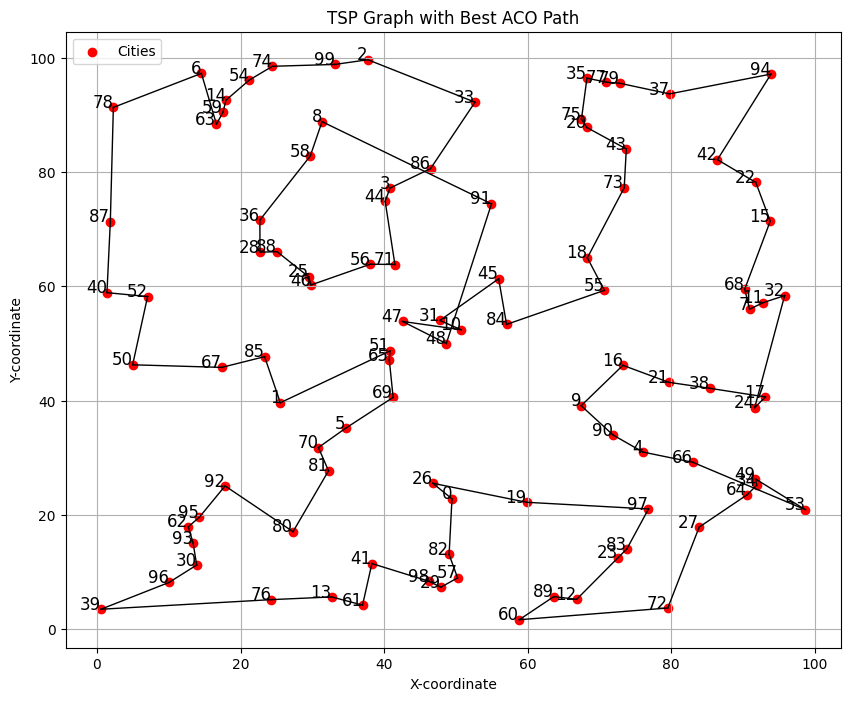

In [ ]:
plt.figure(figsize=(10, 8))

# Scatter plot of cities
plt.scatter(coords[:, 0], coords[:, 1], c='red', marker='o', label='Cities')

# Draw the best path
for i in range(len(best_path) - 1):
    city1_index = best_path[i]
    city2_index = best_path[i+1]
    plt.plot([coords[city1_index, 0], coords[city2_index, 0]],
             [coords[city1_index, 1], coords[city2_index, 1]],
             'k-', linewidth=1)

# Draw the line from the last city back to the first
first_city_index = best_path[0]
last_city_index = best_path[-1]
plt.plot([coords[last_city_index, 0], coords[first_city_index, 0]],
         [coords[last_city_index, 1], coords[first_city_index, 1]],
         'k-', linewidth=1)

# Add labels for cities
for i in range(len(coords)):
    plt.text(coords[i, 0], coords[i, 1], str(i), fontsize=12, ha='right')

plt.title("TSP Graph with Best ACO Path")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.grid(True)
plt.legend()
plt.show()

# **Comparison**
Experiments to compare the ACO with BFS, DFS and A* on TSP problem.

## Implement BFS, DFS and A* for TSP

In [ ]:
def astar_tsp(distances):
    """
    Solve TSP using A* search with optimal state representation.

    Time: O(n! * n) worst case, but pruned by heuristic
    Space: O(n! * n) for visited states
    """
    n = len(distances)
    best_distance = float('inf')
    best_path = None

    # Priority queue: (f_cost, path_as_tuple, current_dist)
    pq = [(0, (start,), 0) for start in range(n)]

    # Track best cost to reach each (visited_set, current_city) state
    visited = {}

    def heuristic(curr, visited_set_frozenset):
        """MST-based heuristic for remaining cities."""
        # Convert frozenset back to a mutable set for easier manipulation
        visited_set = set(visited_set_frozenset)
        unvisited = [i for i in range(n) if i not in visited_set]

        # Handle the case where there are no unvisited cities
        if not unvisited:
            # Return 0 if no unvisited cities left
            return 0.0

        # Min edge from current to unvisited
        # Ensure we don't access distances with invalid indices
        min_edge_curr_unvisited = float('inf')
        for city in unvisited:
            if curr < len(distances) and city < len(distances[curr]):
                 min_edge_curr_unvisited = min(min_edge_curr_unvisited, distances[curr][city])

        h = min_edge_curr_unvisited if min_edge_curr_unvisited != float('inf') else 0.0


        # MST approximation: sum of two smallest edges for each unvisited city
        if len(unvisited) > 1:
            edges = []
            for city in unvisited:
                city_edges = [distances[city][other] for other in range(n)
                             if other != city and other not in visited_set]
                # Add edges to other unvisited cities
                city_edges.extend([distances[city][other] for other in unvisited
                                  if other != city])
                # Only consider if city_edges is not empty to avoid errors with sorted
                if city_edges:
                  edges.extend(sorted(city_edges)[:2])

            # Ensure edges is not empty before summing
            if edges:
              h += sum(sorted(edges)[:len(unvisited)]) / 2

        return h

    while pq:
        f_cost, path, curr_dist = heapq.heappop(pq)
        curr = path[-1]

        # Complete tour found
        if len(path) == n:
            # Ensure the edge back to the start city exists
            if curr < len(distances) and path[0] < len(distances[curr]):
                total = curr_dist + distances[curr][path[0]]
                if total < best_distance:
                    best_distance = total
                    best_path = list(path)
            continue

        # State pruning: skip if we've seen this state with better cost
        visited_set_frozenset = frozenset(path)
        state = (visited_set_frozenset, curr)
        if state in visited and visited[state] <= curr_dist:
            continue
        visited[state] = curr_dist

        # Pruning: skip if current distance already exceeds best
        # Add a small tolerance for floating point comparisons
        if curr_dist >= best_distance - 1e-9: # Use tolerance for comparison
            continue

        # Explore neighbors
        for next_city in range(n):
            if next_city not in visited_set_frozenset:
                # Ensure the edge exists before adding to distance
                if curr < len(distances) and next_city < len(distances[curr]):
                    new_dist = curr_dist + distances[curr][next_city]
                    new_path = path + (next_city,)
                    # Pass the frozenset to the heuristic
                    h = heuristic(next_city, visited_set_frozenset | {next_city})
                    # Check if heuristic is a valid number before pushing to pq
                    if not np.isnan(h) and not np.isinf(h):
                        heapq.heappush(pq, (new_dist + h, new_path, new_dist))


    return best_path, best_distance


def bfs_tsp(distances):
    """
    Solve TSP using BFS with branch-and-bound pruning.

    Time: O(n! * n) worst case
    Space: O(n! * n) for queue
    """
    n = len(distances)
    queue = collections.deque([(tuple([start]), 0) for start in range(n)])

    best_distance = float('inf')
    best_path = None
    convergence = []

    while queue:
        path, curr_dist = queue.popleft()
        curr = path[-1]

        if len(path) == n:
            # Ensure the edge back to the start city exists
            if curr < len(distances) and path[0] < len(distances[curr]):
                total = curr_dist + distances[curr][path[0]]
                if total < best_distance:
                    best_distance = total
                    best_path = list(path)
                    convergence.append(best_distance) # Append when a new best is found
        else:
            visited_set = set(path)
            for next_city in range(n):
                if next_city not in visited_set:
                    # Ensure the edge exists before adding to distance
                    if curr < len(distances) and next_city < len(distances[curr]):
                        new_dist = curr_dist + distances[curr][next_city]
                        # Add a small tolerance for floating point comparisons
                        if new_dist < best_distance - 1e-9:  # Branch-and-bound pruning
                            queue.append((path + (next_city,), new_dist))

    return best_path, best_distance, convergence


def dfs_tsp(distances):
    """
    Solve TSP using DFS with branch-and-bound pruning.

    Time: O(n! * n) worst case
    Space: O(n) recursion depth
    """
    n = len(distances)
    best = {'distance': float('inf'), 'path': None, 'history': []}

    def solve(path, curr_dist, visited_set):
        curr = path[-1]

        if len(path) == n:
            # Ensure the edge back to the start city exists
            if curr < len(distances) and path[0] < len(distances[curr]):
                total = curr_dist + distances[curr][path[0]]
                if total < best['distance']:
                    best['distance'] = total
                    best['path'] = path[:]
                    best['history'].append(best['distance']) # Append when a new best is found
            return

        for next_city in range(n):
            if next_city not in visited_set:
                # Ensure the edge exists before adding to distance
                if curr < len(distances) and next_city < len(distances[curr]):
                    new_dist = curr_dist + distances[curr][next_city]
                    # Add a small tolerance for floating point comparisons
                    if new_dist < best['distance'] - 1e-9:  # Branch-and-bound pruning
                        path.append(next_city)
                        visited_set.add(next_city)
                        solve(path, new_dist, visited_set)
                        path.pop()
                        visited_set.remove(next_city)

    for start in range(n):
        solve([start], 0, {start})

    return best['path'], best['distance'], best['history']

## Robustness

### Run ACO multiple times and visualize the convergence speed


In [ ]:
# Number of independent runs
num_runs = 10

fixed_aco_params = {
    'n_ants': 20,
    'n_iterations': 100,
    'alpha': 1.0,
    'beta': 2.0,
    'evaporation_rate': 0.5,
    'Q': 100,
}

# Number of cities for the TSP instance
n_cities_experiment = 100

print(f"Robustness experiment parameters:")
print(f"  Number of runs: {num_runs}")
print(f"  Number of cities per instance: {n_cities_experiment}")
print(f"  TSP Instance Variation: Different random seeds for city generation per run.")
print(f"  ACO Parameter Variation: Fixed parameters for all runs:")
for param, value in fixed_aco_params.items():
    print(f"    {param}: {value}")


Robustness experiment parameters:
  Number of runs: 10
  Number of cities per instance: 100
  TSP Instance Variation: Different random seeds for city generation per run.
  ACO Parameter Variation: Fixed parameters for all runs:
    n_ants: 20
    n_iterations: 100
    alpha: 1.0
    beta: 2.0
    evaporation_rate: 0.5
    Q: 100


In [ ]:
experiment_results = []

print(f"\nRunning robustness experiment ({num_runs} runs, {n_cities_experiment} cities)...")
print("-" * 60)

for run in range(num_runs):
    print(f"Starting run {run + 1}/{num_runs}...")

    # Generate a new random seed for each run to create a different TSP instance
    run_seed = RANDOM_SEED + run if RANDOM_SEED is not None else int(time.time()) + run
    np.random.seed(run_seed)

    # Generate random city coordinates for the current run
    coords = np.random.rand(n_cities_experiment, 2) * 100

    # Calculate Euclidean distance matrix
    distances = np.zeros((n_cities_experiment, n_cities_experiment))
    for i in range(n_cities_experiment):
        for j in range(n_cities_experiment):
            distances[i, j] = np.linalg.norm(coords[i] - coords[j])

    # Initialize and run ACO with fixed parameters
    aco = AntColonyOptimization(
        distances=distances,
        **fixed_aco_params # Use the fixed parameters defined earlier
    )

    start_time = time.time()
    best_path, best_distance = aco.optimize(verbose=False) # Run ACO without verbose output
    run_time = time.time() - start_time
    convergence_history = aco.convergence_history

    # Store the results for this run
    experiment_results.append({
        'run': run + 1,
        'seed': run_seed,
        'n_cities': n_cities_experiment,
        'aco_params': fixed_aco_params,
        'best_distance': best_distance,
        'best_path': best_path.tolist(), # Convert numpy array to list for easier storage/analysis
        'convergence_history': convergence_history,
        'time': run_time,
    })

    print(f"  Run {run + 1} completed in {run_time:.4f}s. Best Distance: {best_distance:.2f}")

print("-" * 60)
print("Experiment finished.")


Running robustness experiment (10 runs, 100 cities)...
------------------------------------------------------------
Starting run 1/10...


/tmp/ipython-input-3919978297.py:42: RuntimeWarning: divide by zero encountered in divide
  self.heuristic = np.where(distances != 0, 1.0 / distances, 0)


  Run 1 completed in 11.2235s. Best Distance: 826.00
Starting run 2/10...
  Run 2 completed in 11.6714s. Best Distance: 860.21
Starting run 3/10...
  Run 3 completed in 11.7470s. Best Distance: 853.93
Starting run 4/10...
  Run 4 completed in 11.7778s. Best Distance: 892.94
Starting run 5/10...
  Run 5 completed in 11.7594s. Best Distance: 874.02
Starting run 6/10...
  Run 6 completed in 11.7489s. Best Distance: 848.02
Starting run 7/10...
  Run 7 completed in 11.6984s. Best Distance: 854.92
Starting run 8/10...
  Run 8 completed in 11.8110s. Best Distance: 835.78
Starting run 9/10...
  Run 9 completed in 10.7545s. Best Distance: 863.12
Starting run 10/10...
  Run 10 completed in 11.2778s. Best Distance: 890.11
------------------------------------------------------------
Experiment finished.



EXPERIMENT ANALYSIS

Summary Statistics for 10 Runs (N=100 cities):
--------------------------------------------------
Best Distance:
  Mean: 859.91
  Std Dev: 20.36
  Min: 826.00
  Max: 892.94

Execution Time (seconds):
  Mean: 11.5470
  Std Dev: 0.3305
  Min: 10.7545
  Max: 11.8110
--------------------------------------------------

Detailed Results per Run:
Run   | Seed     | Best Distance   | Time (s)  
--------------------------------------------------
1     | 42       | 826.00          | 11.2235   
2     | 43       | 860.21          | 11.6714   
3     | 44       | 853.93          | 11.7470   
4     | 45       | 892.94          | 11.7778   
5     | 46       | 874.02          | 11.7594   
6     | 47       | 848.02          | 11.7489   
7     | 48       | 854.92          | 11.6984   
8     | 49       | 835.78          | 11.8110   
9     | 50       | 863.12          | 10.7545   
10    | 51       | 890.11          | 11.2778   
--------------------------------------------------


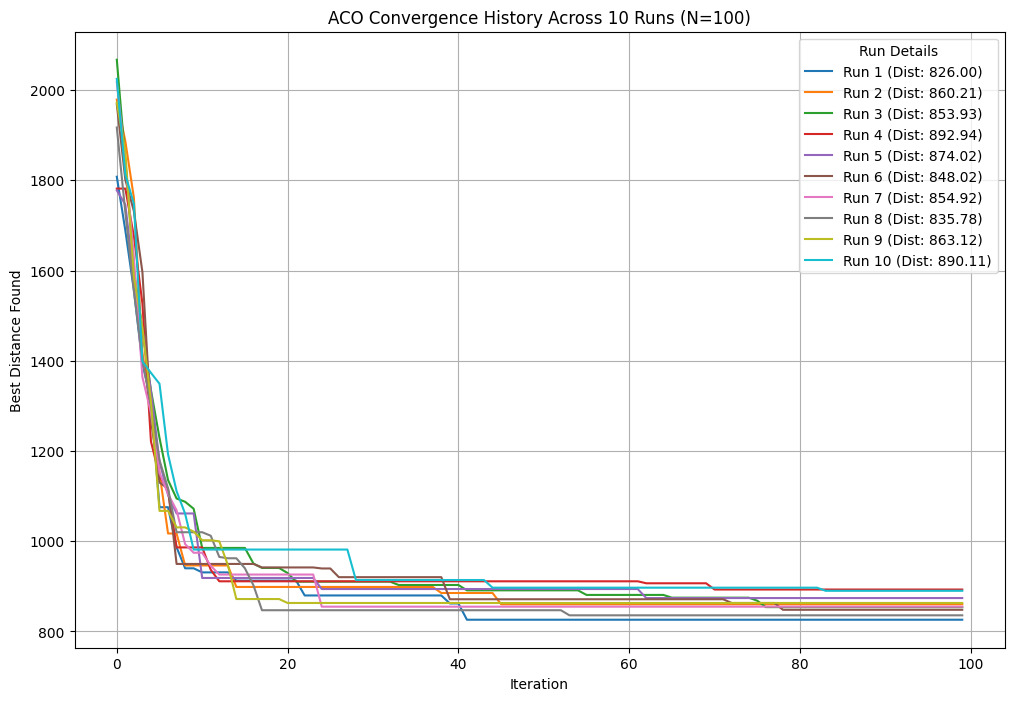


Analysis complete.


In [ ]:
# Analyze and summarize the experiment results

print("\n" + "="*60)
print("EXPERIMENT ANALYSIS")
print("="*60 + "\n")

# Extract best distances and times
best_distances = [result['best_distance'] for result in experiment_results]
execution_times = [result['time'] for result in experiment_results]

# Calculate summary statistics for best distances
mean_distance = np.mean(best_distances)
std_distance = np.std(best_distances)
min_distance = np.min(best_distances)
max_distance = np.max(best_distances)

# Calculate summary statistics for execution times
mean_time = np.mean(execution_times)
std_time = np.std(execution_times)
min_time = np.min(execution_times)
max_time = np.max(execution_times)

print(f"Summary Statistics for {num_runs} Runs (N={n_cities_experiment} cities):")
print("-" * 50)
print(f"Best Distance:")
print(f"  Mean: {mean_distance:.2f}")
print(f"  Std Dev: {std_distance:.2f}")
print(f"  Min: {min_distance:.2f}")
print(f"  Max: {max_distance:.2f}")
print(f"\nExecution Time (seconds):")
print(f"  Mean: {mean_time:.4f}")
print(f"  Std Dev: {std_time:.4f}")
print(f"  Min: {min_time:.4f}")
print(f"  Max: {max_time:.4f}")
print("-" * 50)

# Optional: Print results for each run
print("\nDetailed Results per Run:")
print(f"{'Run':<5} | {'Seed':<8} | {'Best Distance':<15} | {'Time (s)':<10}")
print("-" * 50)
for result in experiment_results:
    print(f"{result['run']:<5} | {result['seed']:<8} | {result['best_distance']:<15.2f} | {result['time']:<10.4f}")
print("-" * 50)

# Optional: Plot convergence histories
plt.figure(figsize=(12, 8))
for i, result in enumerate(experiment_results):
    plt.plot(result['convergence_history'], label=f"Run {result['run']} (Dist: {result['best_distance']:.2f})")

plt.title(f"ACO Convergence History Across {num_runs} Runs (N={n_cities_experiment})")
plt.xlabel("Iteration")
plt.ylabel("Best Distance Found")
plt.legend(title="Run Details")
plt.grid(True)
plt.show()

print("\nAnalysis complete.")
print("="*60)

### Compare runtime between algorithms


In [ ]:
num_comparison_runs = 3

# Different numbers of cities (N) to test
n_values_to_compare = [7, 10, 20, 50]

# Fixed ACO parameters for this comparison
comparison_aco_params = {
    'n_ants': 20,
    'n_iterations': 100,
    'alpha': 1.0,
    'beta': 2.0,
    'evaporation_rate': 0.5,
    'Q': 100,
}

print(f"Comparison experiment parameters:")
print(f"  Number of runs per N: {num_comparison_runs}")
print(f"  N values to compare: {n_values_to_compare}")
print(f"  Fixed ACO parameters for comparison:")
for param, value in comparison_aco_params.items():
    print(f"    {param}: {value}")

Comparison experiment parameters:
  Number of runs per N: 3
  N values to compare: [7, 10, 20, 50]
  Fixed ACO parameters for comparison:
    n_ants: 20
    n_iterations: 100
    alpha: 1.0
    beta: 2.0
    evaporation_rate: 0.5
    Q: 100


In [ ]:
# Structure the experiment loop and run algorithms

comparison_results = {} # Dictionary to store results, keyed by N and then algorithm

print(f"\nStarting Comparison Experiment ({num_comparison_runs} runs per N, N values: {n_values_to_compare})...")
print("=" * 80)

for n in n_values_to_compare:
    print(f"\nTesting N = {n} cities...")
    print("-" * 40)

    # Determine which algorithms are feasible for this N
    runnable_algorithms = {
        'BFS': n <= 10, # BFS becomes very slow quickly
        'DFS': n <= 15, # DFS is generally more memory efficient but still exponential time
        'A*': n <= 15,  # A* is better than brute force but still exponential
        'ACO': True     # ACO is heuristic, generally scales better
    }

    comparison_results[n] = {} # Initialize results dictionary for this N

    for run in range(1, num_comparison_runs + 1):
        print(f"  Run {run}/{num_comparison_runs} for N = {n}...")

        # Generate a new random seed for each run/N combination
        run_seed = int(time.time()) + n * 1000 + run
        np.random.seed(run_seed)

        # Generate random city coordinates
        coords = np.random.rand(n, 2) * 100

        # Calculate Euclidean distance matrix
        distances_np = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                distances_np[i, j] = np.linalg.norm(coords[i] - coords[j])

        distances_list = distances_np.tolist() # Convert for list-based algorithms

        # Run the selected algorithms if feasible
        for algo_name, is_runnable in runnable_algorithms.items():
            if is_runnable:
                print(f"    Running {algo_name}...")
                try:
                    start_time = time.time()
                    best_path = None
                    best_distance = float('inf')
                    convergence = []

                    if algo_name == 'BFS':
                        best_path, best_distance, convergence = bfs_tsp(distances_list)
                    elif algo_name == 'DFS':
                        best_path, best_distance, convergence = dfs_tsp(distances_list)
                    elif algo_name == 'A*':
                        best_path, best_distance = astar_tsp(distances_list)
                        convergence = [best_distance] # A* doesn't track full convergence
                    elif algo_name == 'ACO':
                        # Ensure ACO uses the numpy distance matrix
                        aco = AntColonyOptimization(
                            distances=distances_np,
                            **comparison_aco_params # Use fixed ACO params
                        )
                        best_path, best_distance = aco.optimize(verbose=False)
                        convergence = aco.convergence_history

                    run_time = time.time() - start_time

                    # Store results for this specific run and algorithm
                    if algo_name not in comparison_results[n]:
                        comparison_results[n][algo_name] = []

                    comparison_results[n][algo_name].append({
                        'run': run,
                        'seed': run_seed,
                        'n_cities': n,
                        'best_distance': float(best_distance), # Ensure float
                        'best_path': best_path.tolist() if isinstance(best_path, np.ndarray) else best_path,
                        'convergence_history': [float(d) for d in convergence], # Ensure floats
                        'time': run_time,
                        'status': 'Success'
                    })
                    print(f"      ✓ Completed in {run_time:.4f}s - Distance: {best_distance:.2f}")

                except Exception as e:
                    print(f"      ✗ Failed: {str(e)}")
                    if algo_name not in comparison_results[n]:
                        comparison_results[n][algo_name] = []
                    comparison_results[n][algo_name].append({'status': 'Failed', 'error': str(e), 'run': run, 'seed': run_seed, 'n_cities': n})

            else:
                print(f"    Skipping {algo_name} (N={n} too large)")

    print("-" * 40)

print("=" * 80)
print("Comparison Experiment finished.")


Starting Comparison Experiment (3 runs per N, N values: [7, 10, 20, 50])...

Testing N = 7 cities...
----------------------------------------
  Run 1/3 for N = 7...
    Running BFS...
      ✓ Completed in 0.0178s - Distance: 234.30
    Running DFS...
      ✓ Completed in 0.0057s - Distance: 234.30
    Running A*...
      ✓ Completed in 0.0154s - Distance: 234.30
    Running ACO...


/tmp/ipython-input-3919978297.py:42: RuntimeWarning: divide by zero encountered in divide
  self.heuristic = np.where(distances != 0, 1.0 / distances, 0)


      ✓ Completed in 0.5999s - Distance: 234.30
  Run 2/3 for N = 7...
    Running BFS...
      ✓ Completed in 0.0250s - Distance: 266.48
    Running DFS...
      ✓ Completed in 0.0106s - Distance: 266.48
    Running A*...
      ✓ Completed in 0.0290s - Distance: 266.48
    Running ACO...
      ✓ Completed in 0.8825s - Distance: 266.48
  Run 3/3 for N = 7...
    Running BFS...
      ✓ Completed in 0.0301s - Distance: 222.68
    Running DFS...
      ✓ Completed in 0.0117s - Distance: 222.68
    Running A*...
      ✓ Completed in 0.0277s - Distance: 222.68
    Running ACO...
      ✓ Completed in 0.8315s - Distance: 222.68
----------------------------------------

Testing N = 10 cities...
----------------------------------------
  Run 1/3 for N = 10...
    Running BFS...
      ✓ Completed in 15.3586s - Distance: 295.85
    Running DFS...
      ✓ Completed in 0.8668s - Distance: 295.85
    Running A*...
      ✓ Completed in 0.4065s - Distance: 295.85
    Running ACO...
      ✓ Completed in

## Convergence

Compare convergence of 4 algorithms


In [ ]:
# Define the number of cities (N) for the TSP problem
N = 7

# Generate random city coordinates
np.random.seed(42) # for reproducibility
coords = np.random.rand(N, 2) * 100

# Calculate Euclidean distance matrix
distances = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        distances[i, j] = np.linalg.norm(coords[i] - coords[j])

# Convert the numpy array to a list of lists for BFS, DFS, and A*
distances_list = distances.tolist()

# Convert the list of lists to a NumPy array for ACO
distances_np = np.array(distances_list)


# Run algorithms
if N <= 10: # Adjusted threshold for feasibility
    print(f"Running algorithms for N = {N} cities...")
    aco_small = AntColonyOptimization(
        distances=distances_np,
        n_ants=min(N, 20), # Adjust ants based on N
        n_iterations=min(N*5, 100), # Adjust iterations based on N
        alpha=1.0,
        beta=2.0,
        evaporation_rate=0.5,
        Q=100
    )
    aco_small_best_path, aco_small_best_distance = aco_small.optimize(verbose=False)
    aco_small_convergence = aco_small.convergence_history

    # Run modified BFS on the distance matrix
    bfs_small_best_path, bfs_small_best_distance, bfs_small_convergence = bfs_tsp(distances_list)

    # Run modified DFS on the same distance matrix
    dfs_small_best_path, dfs_small_best_distance, dfs_small_convergence = dfs_tsp(distances_list)

    # Run A* on the distance matrix
    astar_small_best_path, astar_small_best_distance = astar_tsp(distances_list)
    # A* convergence is just the final best distance
    astar_small_convergence = [astar_small_best_distance]


    # Store results
    results = {
        "ACO": {
            "best_path": aco_small_best_path.tolist(),
            "best_distance": aco_small_best_distance,
            "convergence": aco_small_convergence
        },
        "BFS": {
            "best_path": bfs_small_best_path,
            "best_distance": bfs_small_best_distance,
            "convergence": bfs_small_convergence
        },
        "DFS": {
            "best_path": dfs_small_best_path,
            "best_distance": dfs_small_best_distance,
            "convergence": dfs_small_convergence
        },
        "A*": {
            "best_path": astar_small_best_path,
            "best_distance": astar_small_best_distance,
            "convergence": astar_small_convergence
        }
    }

    # Print results for confirmation
    print("\nComparison Results for Small TSP:")
    for algo, res in results.items():
        print(f"\n{algo}:")
        print(f"  Best Distance: {res['best_distance']:.2f}")
        # Ensure path is a list for consistent printing
        path_output = res['best_path']
        if isinstance(path_output, np.ndarray):
             path_output = path_output.tolist()
        print(f"  Best Path: {path_output}")
        print(f"  Convergence History Length: {len(res['convergence'])}")

else:
    print(f"Running ACO for N = {N} cities (BFS, DFS, A* are not feasible for this size)...")
    # Only run ACO for large N
    aco_large = AntColonyOptimization(
        distances=distances_np,
        n_ants=20,
        n_iterations=100,
        alpha=1.0,
        beta=2.0,
        evaporation_rate=0.5,
        Q=100
    )
    aco_large_best_path, aco_large_best_distance = aco_large.optimize(verbose=True)
    aco_large_convergence = aco_large.convergence_history

    results = {
        "ACO": {
            "best_path": aco_large_best_path.tolist(),
            "best_distance": aco_large_best_distance,
            "convergence": aco_large_convergence
        }
    }

    # Print results for confirmation (only ACO)
    print("\nACO Results for Large TSP:")
    print(f"  Best Distance: {results['ACO']['best_distance']:.2f}")
    # Ensure path is a list for consistent printing
    path_output = results['ACO']['best_path']
    if isinstance(path_output, np.ndarray):
         path_output = path_output.tolist()
    print(f"  Best Path: {path_output}")
    print(f"  Convergence History Length: {len(results['ACO']['convergence'])}")

Running algorithms for N = 7 cities...

Comparison Results for Small TSP:

ACO:
  Best Distance: 276.22
  Best Path: [3, 5, 0, 4, 1, 6, 2]
  Convergence History Length: 35

BFS:
  Best Distance: 276.22
  Best Path: [0, 4, 1, 6, 2, 3, 5]
  Convergence History Length: 9

DFS:
  Best Distance: 276.22
  Best Path: [0, 4, 1, 6, 2, 3, 5]
  Convergence History Length: 9

A*:
  Best Distance: 276.22
  Best Path: [2, 6, 1, 4, 0, 5, 3]
  Convergence History Length: 1


/tmp/ipython-input-3919978297.py:42: RuntimeWarning: divide by zero encountered in divide
  self.heuristic = np.where(distances != 0, 1.0 / distances, 0)


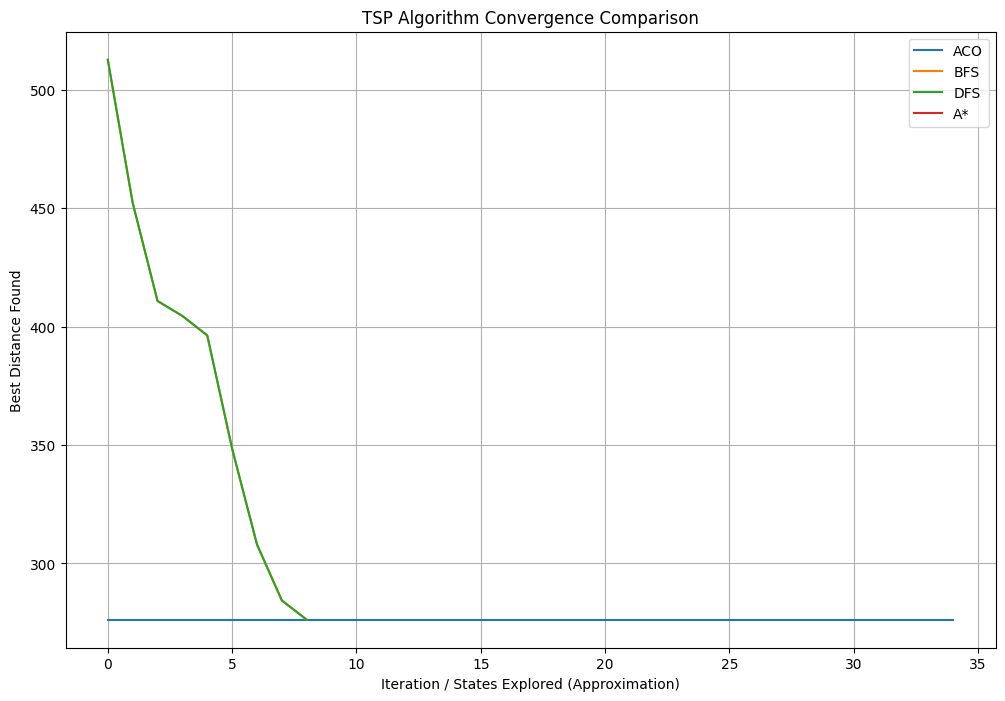

In [ ]:
# Visualize the result of convergence comparison
plt.figure(figsize=(12, 8))

for algo_name, res in results.items():
    convergence_history = res['convergence']
    # Use number of iterations/evaluated paths as x-axis
    plt.plot(range(len(convergence_history)), convergence_history, label=algo_name)

plt.title("TSP Algorithm Convergence Comparison")
plt.xlabel("Iteration / States Explored (Approximation)")
plt.ylabel("Best Distance Found")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print("--- Comparison of Best Results ---")

for algo_name, res in results.items():
    print(f"\n{algo_name}:")
    # Ensure best_distance is a float before formatting
    best_dist = float(res['best_distance'])
    print(f"  Best Distance: {best_dist:.2f}")

    # Ensure path is a list for consistent printing
    best_path_list = res['best_path']
    if isinstance(best_path_list, np.ndarray):
        best_path_list = best_path_list.tolist()
    print(f"  Best Path: {best_path_list}")

# Comment on best distances
distances = [float(res['best_distance']) for res in results.values()]
if all(abs(d - distances[0]) < 1e-6 for d in distances):
    print("\nComment on Distances: All algorithms found the same best distance.")
else:
    print("\nComment on Distances: The best distances found by the algorithms are different.")

# Comment on best paths
paths = [res['best_path'] for res in results.values()]
# Convert numpy arrays to lists for comparison
paths_list = [p.tolist() if isinstance(p, np.ndarray) else p for p in paths]

# Simple check for exact list equality (may not capture cyclically equivalent paths)
if all(p == paths_list[0] for p in paths_list):
     print("Comment on Paths: The best paths found appear to be the same (exact list match).")
else:
     print("Comment on Paths: The best paths found are different (exact list match). Note that paths might be cyclically equivalent even if the lists differ).")


--- Comparison of Best Results ---

ACO:
  Best Distance: 276.22
  Best Path: [3, 5, 0, 4, 1, 6, 2]

BFS:
  Best Distance: 276.22
  Best Path: [0, 4, 1, 6, 2, 3, 5]

DFS:
  Best Distance: 276.22
  Best Path: [0, 4, 1, 6, 2, 3, 5]

A*:
  Best Distance: 276.22
  Best Path: [2, 6, 1, 4, 0, 5, 3]

Comment on Distances: All algorithms found the same best distance.
Comment on Paths: The best paths found are different (exact list match). Note that paths might be cyclically equivalent even if the lists differ).


In [ ]:
# Re-print comparison results for easy reference
print("--- TSP Algorithm Comparison Results ---")
for algo, res in results.items():
    print(f"\n{algo}:")
    print(f"  Best Distance: {float(res['best_distance']):.2f}") # Ensure float for formatting
    # Convert NumPy array to list for consistent output
    path_output = res['best_path']
    if isinstance(path_output, np.ndarray):
        path_output = path_output.tolist()
    print(f"  Best Path: {path_output}")
    print(f"  Convergence History Length: {len(res['convergence'])}")
print("--------------------------------------")

--- TSP Algorithm Comparison Results ---

ACO:
  Best Distance: 276.22
  Best Path: [3, 5, 0, 4, 1, 6, 2]
  Convergence History Length: 35

BFS:
  Best Distance: 276.22
  Best Path: [0, 4, 1, 6, 2, 3, 5]
  Convergence History Length: 9

DFS:
  Best Distance: 276.22
  Best Path: [0, 4, 1, 6, 2, 3, 5]
  Convergence History Length: 9

A*:
  Best Distance: 276.22
  Best Path: [2, 6, 1, 4, 0, 5, 3]
  Convergence History Length: 1
--------------------------------------


# **ACO Visualization**

In [ ]:
class ACOVisualizer:
    def __init__(self, nodes_x, nodes_y, n_ants=6, alpha=1, beta=1,
                 evaporation_rate=0.0, Q=1.0):
        self.nodes_x = nodes_x
        self.nodes_y = nodes_y
        self.n_cities = len(nodes_x)
        self.n_ants = n_ants
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.Q = Q

        # Calculate distance matrix
        self.distances = np.zeros((self.n_cities, self.n_cities))
        for i in range(self.n_cities):
            for j in range(i, self.n_cities):
                dist = sqrt((nodes_x[j] - nodes_x[i])**2 + (nodes_y[j] - nodes_y[i])**2)
                self.distances[i, j] = dist
                self.distances[j, i] = dist

        # Initialize pheromones
        self.pheromones = np.ones((self.n_cities, self.n_cities))

        # Best solution tracking
        self.best_path = None
        self.best_distance = np.sum(self.distances)

        # Visualization setup
        self.images = []
        self.img_index = 0
        self.filename = "TSP_AntColony_Animation"
        self.ax_main = None
        self.ax_optimum = None
        self.fig = None

    def _lighten_color(self, color, amount=0.5):
        """Returns a lighter or darker version of the color."""
        import matplotlib.colors as mc
        import colorsys
        try:
            c = mc.cnames[color]
        except:
            c = color
        c = colorsys.rgb_to_hls(*mc.to_rgb(c))
        return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

    def _capture(self, nframes=1):
        output_dir = '/content/outputs'
        os.makedirs(output_dir, exist_ok=True)

        for i in range(nframes):
            image_path = os.path.join(output_dir, f"{self.filename}_{self.img_index:04d}.png")
            self.img_index += 1
            self.fig.savefig(image_path, dpi=100, bbox_inches='tight')
            self.images.append(image_path)

    def _construct_one_ant_solution(self, ant_num):
        self.ax_main.clear()
        self.ax_main.scatter(self.nodes_x, self.nodes_y, c='black', s=100, zorder=5)
        self.ax_main.set_title(f"Iteration {ant_num + 1} of {self.n_ants}")
        self.ax_main.set_xticks([])
        self.ax_main.set_yticks([])

        current_node = 0
        length = 0
        voyage = [0]
        nodes = set(range(self.n_cities))

        while len(nodes.difference(set(voyage))) > 0:
            unvisited_nodes = []
            probabilities = []
            summation = 0

            # Calculate probabilities for unvisited nodes
            for node in nodes.difference(set(voyage)):
                unvisited_nodes.append(node)
                pheromone = self.pheromones[current_node, node] ** self.alpha
                heuristic_val = 1.0 / self.distances[current_node, node] if self.distances[current_node, node] != 0 else 0
                heuristic = heuristic_val ** self.beta
                probability = pheromone * heuristic
                probabilities.append(probability)
                summation += probability

            probabilities = np.array(probabilities)
            if summation == 0:
                 probabilities = np.ones_like(probabilities) / len(probabilities)
            else:
                 probabilities = probabilities / summation

            # Draw each possible path with transparency based on probability
            lines = []
            for i, node in enumerate(unvisited_nodes):
                line = self.ax_main.plot([self.nodes_x[current_node], self.nodes_x[node]],
                                        [self.nodes_y[current_node], self.nodes_y[node]],
                                        c='blue', alpha=probabilities[i], linewidth=2)[0]
                lines.append(line)
            self._capture()

            # Choose next node
            if np.isnan(probabilities).any() or np.isinf(probabilities).any():
                 chosen_node = random.choice(unvisited_nodes)
            else:
                 chosen_node = random.choices(unvisited_nodes, weights=probabilities, k=1)[0]

            # Mark chosen path as green, remove others
            for i, node in enumerate(unvisited_nodes):
                if node == chosen_node:
                    lines[i].set_color('green')
                    lines[i].set_alpha(1)
                    lines[i].set_linewidth(3)
                else:
                    lines[i].remove()
            self._capture()

            length += self.distances[current_node, chosen_node]
            current_node = chosen_node
            voyage.append(current_node)

        # Return to start
        length += self.distances[current_node, 0]
        voyage.append(0)

        return voyage, length

    def _update_optimum_display(self):
        """Update the optimum path visualization."""
        self.ax_optimum.clear()
        self.ax_optimum.scatter(self.nodes_x, self.nodes_y, c='black', s=100, zorder=5)
        self.ax_optimum.set_xticks([])
        self.ax_optimum.set_yticks([])
        self.ax_optimum.set_title(f"Best: {round(self.best_distance, 2)}m", fontsize=14)
        if self.best_path:
            for i in range(len(self.best_path) - 1):
                self.ax_optimum.plot([self.nodes_x[self.best_path[i]], self.nodes_x[self.best_path[i + 1]]],
                                    [self.nodes_y[self.best_path[i]], self.nodes_y[self.best_path[i + 1]]],
                                    c=self._lighten_color('green'), linewidth=2)
            # Draw return to start
            self.ax_optimum.plot([self.nodes_x[self.best_path[-1]], self.nodes_x[self.best_path[0]]],
                                [self.nodes_y[self.best_path[-1]], self.nodes_y[self.best_path[0]]],
                                c=self._lighten_color('green'), linewidth=2)

    def run_visualization(self, fps=2):
        # Setup visualization figure with side-by-side subplots
        self.fig, (self.ax_main, self.ax_optimum) = plt.subplots(1, 2, figsize=(16, 8))

        # Configure optimum axis
        self.ax_optimum.set_xticks([])
        self.ax_optimum.set_yticks([])
        self.ax_optimum.set_title("Current Best", fontsize=14)
        self.ax_optimum.scatter(self.nodes_x, self.nodes_y, c='black', s=100, zorder=5)

        # Initial capture
        self._capture(2)

        for ant in range(self.n_ants):
            # Construct solution with visualization
            voyage, length = self._construct_one_ant_solution(ant)

            # Update best solution
            if length < self.best_distance:
                self.best_distance = length
                self.best_path = voyage
                self._update_optimum_display()
                self._capture(3)

            # Draw complete voyage
            self.ax_main.plot([self.nodes_x[voyage[-2]], self.nodes_x[voyage[0]]],
                            [self.nodes_y[voyage[-2]], self.nodes_y[voyage[0]]],
                            c='green', linewidth=3)
            self.ax_main.set_title(f"Iteration {ant + 1} of {self.n_ants} - Length: {round(length, 2)}m")
            self._capture(3)

            # Apply evaporation
            if self.evaporation_rate > 0:
                self.pheromones *= (1 - self.evaporation_rate)

            # Deposit pheromones for this path
            for i in range(len(voyage) - 1):
                self.pheromones[voyage[i], voyage[i+1]] += self.Q / length if length > 0 else 0
                self.pheromones[voyage[i+1], voyage[i]] += self.Q / length if length > 0 else 0

            # Show pheromone levels
            self.ax_main.clear()
            self.ax_main.scatter(self.nodes_x, self.nodes_y, c='black', s=100, zorder=5)
            self.ax_main.set_title(f"Iteration {ant + 1} - Pheromone Levels")
            self.ax_main.set_xticks([])
            self.ax_main.set_yticks([])

            max_pheromone = np.max(self.pheromones) if np.max(self.pheromones) > 0 else 1
            for i in range(self.n_cities):
                for j in range(i + 1, self.n_cities):
                     alpha_level = self.pheromones[i, j] / max_pheromone
                     if alpha_level > 0.01:  # Only show significant pheromone trails
                         self.ax_main.plot([self.nodes_x[i], self.nodes_x[j]],
                                        [self.nodes_y[i], self.nodes_y[j]],
                                        c='red', alpha=alpha_level, linewidth=2)
            self._capture(3)

        # Create final image
        plt.close(self.fig)
        self.fig, ax = plt.subplots(figsize=(10, 8))
        ax.scatter(self.nodes_x, self.nodes_y, c='black', s=100, zorder=5)
        ax.set_title(f"FINAL RESULT - Best Distance: {round(self.best_distance, 2)}m", fontsize=16)
        ax.set_xticks([])
        ax.set_yticks([])
        if self.best_path:
            for i in range(len(self.best_path) - 1):
                ax.plot([self.nodes_x[self.best_path[i]], self.nodes_x[self.best_path[i + 1]]],
                       [self.nodes_y[self.best_path[i]], self.nodes_y[self.best_path[i + 1]]],
                       c='green', linewidth=3)
            # Draw return to start
            ax.plot([self.nodes_x[self.best_path[-1]], self.nodes_x[self.best_path[0]]],
                    [self.nodes_y[self.best_path[-1]], self.nodes_y[self.best_path[0]]],
                    c='green', linewidth=3)

        output_dir = '/content/outputs'
        self.fig.savefig(os.path.join(output_dir, f"{self.filename}_final.png"), dpi=150, bbox_inches='tight')
        self._capture(4)

        # Create animation using PIL (more reliable than ImageMagick in Colab)
        print("Creating animation...")
        gif_filename = os.path.join(output_dir, self.filename + '.gif')

        try:
            from PIL import Image as PILImage
            frames = []
            for img_path in self.images:
                frames.append(PILImage.open(img_path))

            # Save as GIF
            frames[0].save(
                gif_filename,
                save_all=True,
                append_images=frames[1:],
                duration=1000//fps,
                loop=0
            )
            print(f"Animation created successfully!")
        except Exception as e:
            print(f"Error creating GIF: {e}")
            print("Trying ImageMagick fallback...")
            try:
                image_list = ' '.join([f'"{img}"' for img in self.images])
                os.system(f'convert -delay {100//fps} -loop 0 {image_list} "{gif_filename}"')
                print("Animation created with ImageMagick!")
            except:
                print("Could not create GIF. Individual frames saved in /content/outputs/")

        # Clean up temporary images
        print("Cleaning up temporary files...")
        for img_path in self.images:
            if os.path.exists(img_path):
                try:
                    os.remove(img_path)
                except:
                    pass

        print(f"\n{'='*60}")
        print(f"Animation saved: {gif_filename}")
        print(f"Best path: {self.best_path}")
        print(f"Best distance: {self.best_distance:.2f}")
        print(f"{'='*60}\n")

        # Display GIF in Colab
        try:
            print("Displaying animation:")
            time.sleep(0.5)
            display(Image(filename=gif_filename))
        except Exception as e:
            print(f"Could not display GIF: {e}")

        plt.close('all')

        return self.best_path, self.best_distance


ACO TRAVELING SALESMAN PROBLEM SOLVER

Running ACO visualization for 10 cities...

Creating animation...
Animation created successfully!
Cleaning up temporary files...

Animation saved: /content/outputs/TSP_AntColony_Animation.gif
Best path: [0, 2, 1, 3, 9, 8, 7, 6, 5, 4, 0]
Best distance: 383.96

Displaying animation:


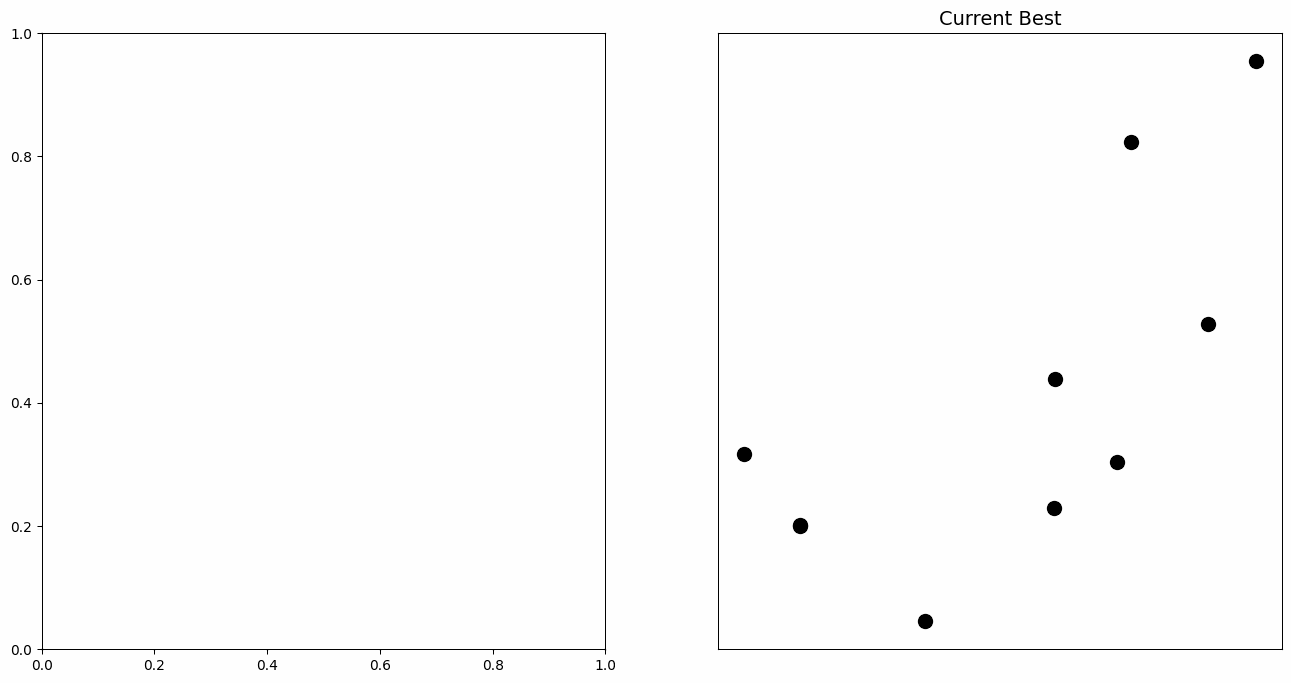


Done! Check /content/outputs/ for the GIF file.


In [ ]:
print("\n" + "="*60)
print("ACO TRAVELING SALESMAN PROBLEM SOLVER")
print("="*60 + "\n")

N = 10 # You can change N to a different number

# Generate random city coordinates
np.random.seed(42) # for reproducibility
nodes_x = np.random.rand(N) * 100 # Random x-coordinates in a 100x100 area
nodes_y = np.random.rand(N) * 100


    # Example: Using the visualizer
print(f"Running ACO visualization for {N} cities...\n")

visualizer = ACOVisualizer(
    nodes_x=nodes_x,
    nodes_y=nodes_y,
    n_ants=min(N, 20), # Adjust number of ants based on N
    alpha=1,
    beta=1,
    evaporation_rate=0.1,
    Q=1.0
)

best_path, best_distance = visualizer.run_visualization(fps=1)

print("\nDone! Check /content/outputs/ for the GIF file.")